### Auxillay Classifier GAN with D operating on embedding space

In [9]:
import torch
from torch.autograd import Variable

## custom dataloaders
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
from networks import EmbeddingNet, TripletNet, SiameseNet, LeNet

import matplotlib
import matplotlib.pyplot as plt

import time

import numpy as np

In [10]:
# first load the generator and discriminator models
from model_AC_Lenet import Generator, Discriminator

In [11]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda=1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = TripletNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'triplet'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))
print model

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

TripletNet (
  (embedding_net_1): LeNet (
    (convnet): Sequential (
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU ()
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU ()
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (400 -> 120)
      (1): ReLU ()
      (2): Linear (120 -> 84)
    )
  )
  (embedding_net_2): LeNet (
    (convnet): Sequential (
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU ()
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU ()
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (400 -> 120)
      (1): ReLU ()
      (2): Linear (120 -> 84)
    )
  )
)


In [12]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [13]:
batchSize = 128

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64
numPrimaryOutputChannels = getChannels(primaryDataset)
numHelperOutputChannels = getChannels(helperDataset)

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

G = Generator(numNoiseChannels, 
              numClasses, 
              numGenFilter, 
              numPrimaryOutputChannels)

D = Discriminator(numClasses)

G = G.cuda()
D = D.cuda()

In [14]:
classes = [i for i in range(10)]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')
trainDatasetHelper = loadDataset(helperDataset, classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')
testDatasetHelper = loadDataset(helperDataset, classes, instances, 'test' )

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)
helperTrainLoader = torch.utils.data.DataLoader(trainDatasetHelper, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)
helperTestLoader = torch.utils.data.DataLoader(testDatasetHelper, batch_size=batchSize, shuffle=True, **kwargs)

<img src="./images/ac-gan.png"  >


In [26]:
# train using the primary class only 

def train(primaryTrainLoader,
          helperTrainLoader,
          primaryClassFlag = True,
          helperClassFlag = True,
          learningRate = 0.0002,
          epochs=20):
    
    G = Generator(numNoiseChannels, 
                  numClasses, 
                  numGenFilter, 
                  numPrimaryOutputChannels)
    D = Discriminator(numClasses)

    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)

    # define loss function and optimizers
    lossFunction = nn.BCELoss()
    
    # classification loss as an auxillary task
    classifyLossFunction = nn.NLLLoss()


    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator pertaining primary class
    discRealInputPrimary = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    
    # real input to the discriminator
    discRealInputHelper = torch.FloatTensor(batchSize,
                                      numHelperOutputChannels,
                                      imageSize,
                                      imageSize)
    
    # label is 1 for real examples and 0 for generated examples
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numNoiseChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        classifyLossFunction = classifyLossFunction.cuda()
        
        discRealInputPrimary = discRealInputPrimary.cuda()
        discRealInputHelper = discRealInputHelper.cuda()
        
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # train using theta - the embedding of primary class only
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        primaryEpochstartTime = time.time()
        
        if primaryClassFlag:
            for i,data in enumerate(primaryTrainLoader, 0):

                # train discriminator D

                # set the gradients in computation graph of discriminator to be 0
                D.zero_grad()
                dataInstance, dataClass = data

                # one-hot encoding for discriminator class input
                dataClassOH = oneHotDisc[dataClass]

                if cuda:
                    dataInstance = dataInstance.cuda()
                    dataClass = dataClass.cuda()
                    dataClassOH = dataClassOH.cuda()


                #print discRealInputPrimary.shape, dataInstance.shape

                # train discriminator on real classes
                discRealInputPrimary.copy_(dataInstance)
                discRealInputClass.copy_(dataClassOH)
        
                dataClassV = Variable(dataClass)
                discRealInputPrimaryV = Variable(discRealInputPrimary)
                discRealInputClassV = Variable(discRealInputClass)
                discRealLabelV = Variable(discRealLabel)


                ## given embedding of the real data instead of image to disceriminator
                ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
                #print discRealInputV
                discRealInputEmbedding = model.get_embedding(discRealInputPrimaryV, 'primary')

                discRealOutput, discClassOutput = D(discRealInputEmbedding,
                                   discRealInputClassV)

                #print discClassOutput.data.shape, dataClassV.data.shape
                discLossReal = lossFunction(discRealOutput,
                                            discRealLabelV) + classifyLossFunction(discClassOutput, 
                                                                                      dataClassV)

                # calculate the gradients for nodes of computation graph
                discLossReal.backward()

                # train discriminator on fake classes
                #  p=getProbDist(primaryInstanceList)
                dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
                discFakeInputClass = oneHotDisc[dataFakeClass]
                genFakeInputClass = oneHotGen[dataFakeClass]

                if cuda:
                    dataFakeClass = dataFakeClass.cuda()
                    discFakeInputClass = discFakeInputClass.cuda()
                    genFakeInputClass = genFakeInputClass.cuda()


                discFakeInput.normal_(0,1)
                
                dataFakeClassV = Variable(dataFakeClass)
                discFakeInputClassV= Variable(discFakeInputClass)
                genFakeInputClassV = Variable(genFakeInputClass)
                discFakeInputV = Variable(discFakeInput)
                discFakeLabelV = Variable(discFakeLabel)


                genFakeOutput = G(discFakeInputV,
                                  genFakeInputClassV)
                #genFakeOutput = genFakeOutput.view(batchSize,-1)

                # get the 84 dimensional embedding of generator output
                genFakeOutputEmbedding = model.get_embedding(genFakeOutput, 'primary')

                # detach the graph prior to D. So what weights in G do not get updated
                #print genFakeOutput.data.shape, discFakeInputClassV.data.shape

                discFakeOutput, discClassOutput = D(genFakeOutputEmbedding.detach(),
                                   discFakeInputClassV)

                discLossFake = lossFunction(discFakeOutput,
                                            discFakeLabelV) + classifyLossFunction(discClassOutput,
                                                                                   dataFakeClassV)

                # calculate the gradients for nodes of computation graph
                discLossFake.backward()

                # log the loss for discriminator
                discriminatorLosses.append((discLossReal+discLossFake).data[0])

                # update the weights
                discOptimizer.step()

                # train generator with discriminator feedback
                G.zero_grad()


                # have to freeze weights of theta
                discFakeOutput, discClassOutput = D(genFakeOutputEmbedding,
                                   discFakeInputClassV)

                genLossFake = lossFunction(discFakeOutput, 
                                           discRealLabelV) + classifyLossFunction(discClassOutput,
                                                                                  dataFakeClassV)

                genLossFake.backward()
                genOptimizer.step()

                # log the loss for generator
                generatorLosses.append(genLossFake.data[0])
        
        if helperClassFlag:
            ### training with helper class
            for i,data in enumerate(helperTrainLoader, 0):

                # train discriminator D

                # set the gradients in computation graph of discriminator to be 0
                D.zero_grad()
                dataInstance, dataClass = data

                # one-hot encoding for discriminator class input
                dataClassOH = oneHotDisc[dataClass]

                if cuda:
                    dataClass = dataClass.cuda()
                    dataInstance = dataInstance.cuda()
                    dataClassOH = dataClassOH.cuda()


                #print discRealInput.shape, dataInstance.shape

                # train discriminator on real classes
                #print discRealInputClass.shape, dataClass.shape
                
                discRealInputHelper.copy_(dataInstance)
                discRealInputClass.copy_(dataClassOH)
                
                dataClassV = Variable(dataClass)
                discRealInputHelperV = Variable(discRealInputHelper)
                discRealInputClassV = Variable(discRealInputClass)
                discRealLabelV = Variable(discRealLabel)


                ## given embedding of the real data instead of image to disceriminator
                ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
                #print discRealInputV
                discRealInputEmbedding = model.get_embedding(discRealInputHelperV, 'helper')

                discRealOutput, discClassOutput = D(discRealInputEmbedding,
                                   discRealInputClassV)


                discLossReal = lossFunction(discRealOutput,
                                            discRealLabelV) + classifyLossFunction(discClassOutput, 
                                                                                   dataClassV)

                # calculate the gradients for nodes of computation graph
                discLossReal.backward()

                # train discriminator on fake classes
                #  p=getProbDist(primaryInstanceList)
                dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
                discFakeInputClass = oneHotDisc[dataFakeClass]
                genFakeInputClass = oneHotGen[dataFakeClass]

                if cuda:
                    
                    dataFakeClass = dataFakeClass.cuda()
                    discFakeInputClass = discFakeInputClass.cuda()
                    genFakeInputClass = genFakeInputClass.cuda()


                discFakeInput.normal_(0,1)
                
                dataFakeClassV = Variable(dataFakeClass)
                discFakeInputClassV= Variable(discFakeInputClass)
                genFakeInputClassV = Variable(genFakeInputClass)
                discFakeInputV = Variable(discFakeInput)
                discFakeLabelV = Variable(discFakeLabel)


                genFakeOutput = G(discFakeInputV,
                                  genFakeInputClassV)
                #genFakeOutput = genFakeOutput.view(batchSize,-1)

                # get the 84 dimensional embedding of generator output
                genFakeOutputEmbedding = model.get_embedding(genFakeOutput, 'primary')

                # detach the graph prior to D. So what weights in G do not get updated
                #print genFakeOutput.data.shape, discFakeInputClassV.data.shape

                discFakeOutput, discClassOutput = D(genFakeOutputEmbedding.detach(),
                                   discFakeInputClassV)

                discLossFake = lossFunction(discFakeOutput,
                                            discFakeLabelV) + classifyLossFunction(discClassOutput,
                                                                                   dataFakeClassV)

                # calculate the gradients for nodes of computation graph
                discLossFake.backward()

                # log the loss for discriminator
                discriminatorLosses.append((discLossReal+discLossFake).data[0])

                # update the weights
                discOptimizer.step()

                # train generator with discriminator feedback
                G.zero_grad()


                # have to freeze weights of theta
                discFakeOutput, discClassOutput = D(genFakeOutputEmbedding,
                                   discFakeInputClassV)

                genLossFake = lossFunction(discFakeOutput, 
                                           discRealLabelV) + classifyLossFunction(discClassOutput,
                                                                                  dataFakeClassV)

                genLossFake.backward()
                genOptimizer.step()

                # log the loss for generator
                generatorLosses.append(genLossFake.data[0])



        epochEndTime = time.time()
        perEpochTime = epochEndTime - primaryEpochstartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    
    
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

Epoch : [1/20] time: 17.88, loss_d: 0.917, loss_g: 0.484
Epoch : [2/20] time: 17.89, loss_d: 0.390, loss_g: 0.199
Epoch : [3/20] time: 18.27, loss_d: 0.033, loss_g: 0.020
Epoch : [4/20] time: 20.08, loss_d: -0.272, loss_g: -0.131
Epoch : [5/20] time: 20.09, loss_d: -0.485, loss_g: -0.240
Epoch : [6/20] time: 20.08, loss_d: -0.556, loss_g: -0.276
Epoch : [7/20] time: 20.06, loss_d: -0.581, loss_g: -0.289
Epoch : [8/20] time: 20.04, loss_d: -0.593, loss_g: -0.295
Epoch : [9/20] time: 20.11, loss_d: -0.600, loss_g: -0.298
Epoch : [10/20] time: 20.08, loss_d: -0.606, loss_g: -0.299
Epoch : [11/20] time: 20.10, loss_d: -0.609, loss_g: -0.301
Epoch : [12/20] time: 20.06, loss_d: -0.611, loss_g: -0.301
Epoch : [13/20] time: 20.07, loss_d: -0.614, loss_g: -0.300
Epoch : [14/20] time: 20.05, loss_d: -0.616, loss_g: -0.301
Epoch : [15/20] time: 20.04, loss_d: -0.621, loss_g: -0.299
Epoch : [16/20] time: 20.07, loss_d: -0.625, loss_g: -0.295
Epoch : [17/20] time: 20.05, loss_d: -0.629, loss_g: -0

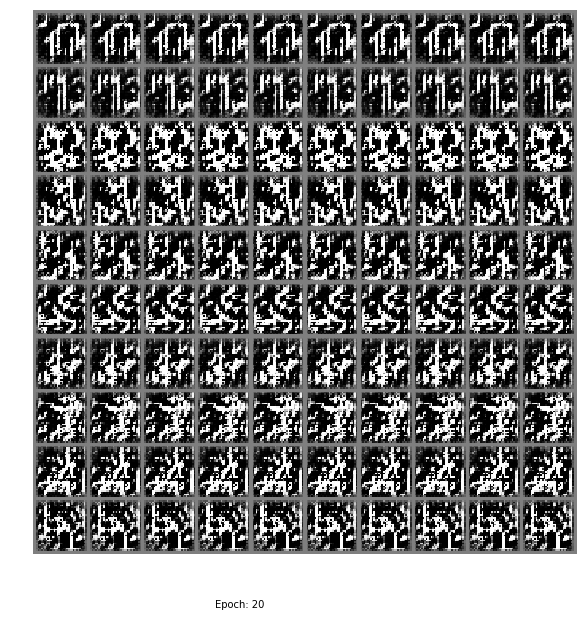

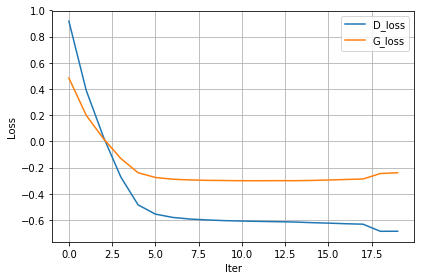

In [20]:
train(primayTrainLoader, helperTrainLoader, epochs=20, helperClassFlag = False)

Epoch : [1/20] time: 36.89, loss_d: 0.595, loss_g: 0.319
Epoch : [2/20] time: 39.99, loss_d: -0.271, loss_g: -0.131
Epoch : [3/20] time: 40.69, loss_d: -0.556, loss_g: -0.274
Epoch : [4/20] time: 40.68, loss_d: -0.626, loss_g: -0.271
Epoch : [5/20] time: 40.72, loss_d: -0.732, loss_g: -0.200
Epoch : [6/20] time: 40.66, loss_d: -0.859, loss_g: -0.089
Epoch : [7/20] time: 40.88, loss_d: -0.961, loss_g: 0.030
Epoch : [8/20] time: 40.71, loss_d: -1.040, loss_g: 0.155
Epoch : [9/20] time: 40.64, loss_d: -1.079, loss_g: 0.239
Epoch : [10/20] time: 40.66, loss_d: -1.147, loss_g: 0.371
Epoch : [11/20] time: 40.64, loss_d: -1.168, loss_g: 0.456
Epoch : [12/20] time: 40.65, loss_d: -1.194, loss_g: 0.490
Epoch : [13/20] time: 40.72, loss_d: -1.182, loss_g: 0.553
Epoch : [14/20] time: 40.78, loss_d: -1.261, loss_g: 0.618
Epoch : [15/20] time: 40.69, loss_d: -1.340, loss_g: 0.753
Epoch : [16/20] time: 40.64, loss_d: -1.333, loss_g: 0.786
Epoch : [17/20] time: 40.74, loss_d: -1.401, loss_g: 0.805
Ep

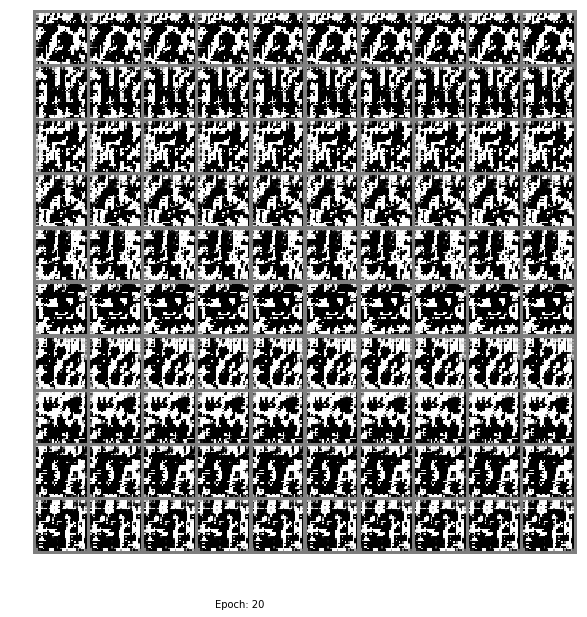

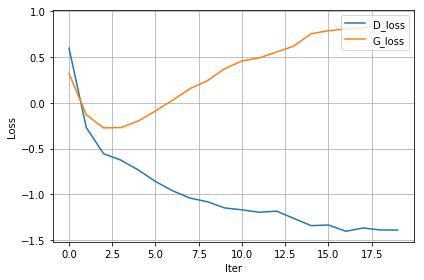

In [27]:
train(primayTrainLoader, helperTrainLoader, epochs=20, helperClassFlag = True)